# Example calculations with scalar quantities

## Objectives

To demonstrate basic calculations using scalar fields (e.g., SSH, T, S) from the state estimate including: time series of mean quantities, spatial patterns of mean quantities, spatial patterns of linear trends, and spatial patterns of linear trends over different time periods.

## Introduction

We will demonstrate global calculations with SSH (global mean sea level time series, mean dynamic topography, global mean sea level trend) and a regional calculation with THETA (The Nino 3.4 index).

For this tutorial we will need the grid file, monthly SSH and THETA (potential temperature) spanning the years 1993 through 2017, and daily SSH for the year 1994. If you need to download these data from PO.DAAC, the ShortNames of the datasets are:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4** (1993-2017)
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4** (1993-2017)
- **ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4** (1994)

## Global calculations with SSH

First, load SSH and THETA fields and the model grid parameters.

In [1]:
import numpy as np
import sys
import xarray as xr
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [4]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

Now we'll load daily SSH from 1994. We will do this in two ways. The first way uses ``open_mfdataset`` which opens the files with the data variables as dask arrays first, then we load the dask arrays into memory. The second way creates a list of the files using ``glob``, then loads each file into memory using ``open_dataset``, no dask involved. Note the difference in wall time (on a laptop):

In [5]:
%%time
## using open_mfdataset/dask
ds_SSH_daily_1994 = xr.open_mfdataset(join(ECCO_dir,'*SSH*DAILY*','*_1994-*.nc'))
ds_SSH_daily_1994 = ds_SSH_daily_1994.drop_vars(['SSHNOIBC','SSHIBC','ETAN'])
ecco_daily_ds = xr.merge((ecco_grid,ds_SSH_daily_1994)).load()

Wall time: 3min 15s


In [6]:
%%time
## without using dask

def ds_load_concat(file_list,dim_concat,vars_to_drop):
    for count,file in enumerate(file_list):
        if count == 0:
            ds_out = xr.open_dataset(file)
            # remove variables not needed
            ds_out = ds_out.drop_vars(vars_to_drop)
        else:
            ds_curr = xr.open_dataset(file)
            # remove variables not needed
            ds_curr = ds_curr.drop_vars(vars_to_drop)
            # concatenate along dimension with name dim_concat
            ds_out = xr.concat((ds_out,ds_curr),dim=dim_concat)
    return ds_out
    
SSH_daily_files = glob.glob(join(ECCO_dir,'*SSH*DAILY*','*_1994-*.nc'))
ds_SSH_daily_1994 = ds_load_concat(SSH_daily_files,dim_concat='time',\
                                   vars_to_drop=['SSHNOIBC','SSHIBC','ETAN'])
ecco_daily_ds = xr.merge((ecco_grid,ds_SSH_daily_1994))

Wall time: 39.8 s


This illustrates that it is not *always* faster to use dask. In this case, we are opening a lot of individual (daily) files and loading their contents into memory right away. Using dask, this generates a lot of (relatively small) chunks that have to be unpacked when loaded into memory.

Dask does better when opening larger individual files (e.g., files that encompass the full 3-D ocean), and when datasets are being subsetted or processed in some way before they are fully loaded into memory.

Now load monthly mean SSH, 1993-2017, using the non-dask method.

In [7]:
%%time
## Load monthly SSH and THETA data

SSH_monthly_files_1990s = glob.glob(join(ECCO_dir,'*SSH*MONTHLY*','*_199[3-9]-*.nc'))
SSH_monthly_files_2000s = glob.glob(join(ECCO_dir,'*SSH*MONTHLY*','*_20[01]?-*.nc'))
# concatenate 2 file lists
SSH_monthly_files = SSH_monthly_files_1990s + SSH_monthly_files_2000s

ds_SSH_monthly = ds_load_concat(SSH_monthly_files,dim_concat='time',\
                                vars_to_drop=['SSHNOIBC','SSHIBC','ETAN'])

Wall time: 33.9 s


And monthly mean THETA, 1993-2017. But since these are larger files containing the full depth of the ocean, *and* we are subsetting the dataset (by removing the SALT variable that we don't need), it is advantageous to use Dask here.

In [8]:
%%time
ds_TSAL_monthly_1990s = xr.open_mfdataset(join(ECCO_dir,'*TEMP_SALINITY*MONTHLY*','*_199[3-9]-*.nc'))
ds_TSAL_monthly_2000s = xr.open_mfdataset(join(ECCO_dir,'*TEMP_SALINITY*MONTHLY*','*_20[01]?-*.nc'))
# concatenate 2 datasets
ds_THETA_monthly = xr.concat((ds_TSAL_monthly_1990s.drop_vars('SALT'),\
                              ds_TSAL_monthly_2000s.drop_vars('SALT')),dim='time')

## Merge the ecco_grid with the data variables to make ecco_monthly_ds
ecco_monthly_ds = xr.merge((ecco_grid,ds_SSH_monthly,ds_THETA_monthly)).load()

Wall time: 4min 37s


Display the first and last time entries in each dataset:

In [9]:
print(ecco_daily_ds.time[0].values)
print(ecco_daily_ds.time[-1].values)

print(ecco_monthly_ds.time[0].values)
print(ecco_monthly_ds.time[-1].values)

1994-01-01T12:00:00.000000000
1994-12-31T12:00:00.000000000
1993-01-16T12:00:00.000000000
2017-12-16T06:00:00.000000000


## Sea surface height

### Global mean sea level

Global mean sea surface height at time $t$ is defined as follows:

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

$$A_{\text{global ocean}} = \sum_{i} A(i)$$

Where $SSH(i,t)$ is dynamic height at model grid cell $i$ and time $t$, $A(i)$ is the area (m^2) of model grid cell $i$

There are several ways of doing the above calculations.  Since this is the first tutorial with actual calcuations, we'll present a few different approaches for getting to the same answer.

#### Part 1: $A_{\text{global ocean}}$

Let's start on the simplest quantity, the global ocean surface area $A_{\text{global ocean}}$.  Our calculation uses *SSH* which is a 'c' point variable.  The surface area of tracer grid cells is provided by the model grid parameter *rA*.  *rA* is a two-dimensional field that is defined over all model grid points, including land.  

To calculate the total ocean surface area we need to ignore the area contributions from land. 

We will first construct a 3D mask that is True for model grid cells that are wet and False for model grid cells that are dry cells.  

In [10]:
# ocean_mask is ceiling of hFacC which is 0 for 100% dry cells and
# 0 > hFacC >= 1 for grid cells that are at least partially wet

# hFacC is the fraction of the thickness (h) of the grid cell which
# is wet.  we'll consider all hFacC > 0 as being a wet grid cell
# and so we use the 'ceiling' function to make all values > 0 equal to 1.

ocean_mask = np.ceil(ecco_monthly_ds.hFacC)
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [11]:
# print the dimensions and size of ocean_mask
print(type(ocean_mask))
print((ocean_mask.dims))

<class 'xarray.core.dataarray.DataArray'>
('k', 'tile', 'j', 'i')


<Figure size 1080x540 with 0 Axes>

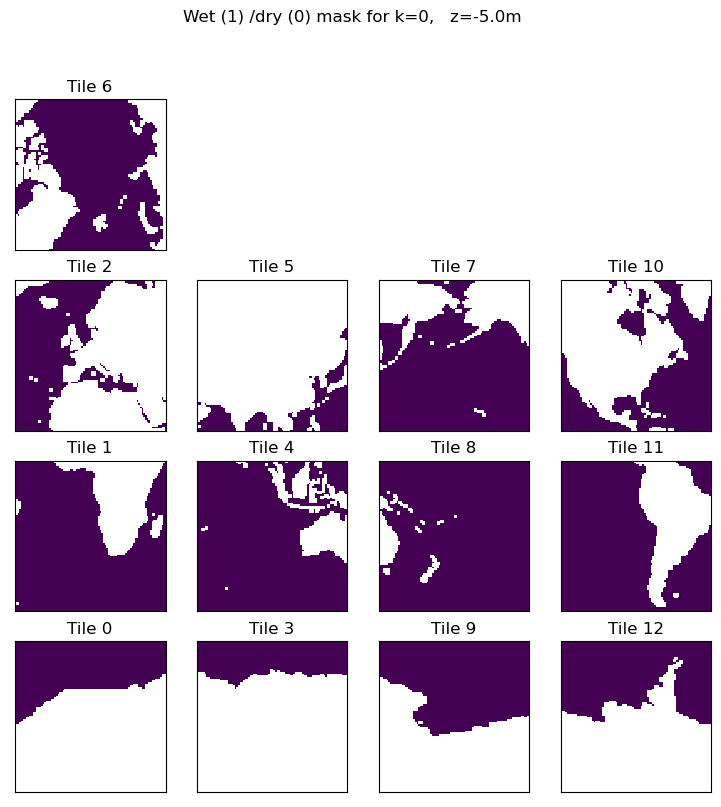

In [12]:
plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_tiles(ocean_mask.isel(k=0),layout='latlon', rotate_to_latlon=True)

# select out the model depth at k=1, round the number and convert to string.
z = str((np.round(ecco_monthly_ds.Z.values[0])))
plt.suptitle('Wet (1) /dry (0) mask for k=' + str(0) + ',   z=' + z + 'm');

To calculate $A_{\text{global ocean}}$ we must apply the surface wet/dry mask to $rA$.  

In [13]:
# Method 1: the array index method, []
#           select land_c at k index 0
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])

# these three methods give the same numerical result.  Here are 
# three alternative ways of printing the result
print ('total ocean surface area ( m^2) %d  ' % total_ocean_area.values)
print ('total ocean surface area (km^2) %d ' % (total_ocean_area.values/1.0e6))

# or in scientific notation with 2 decimal points
print ('total ocean surface area (km^2) %.2E' % (total_ocean_area.values/1.0e6))

total ocean surface area ( m^2) 358013844062208  
total ocean surface area (km^2) 358013844 
total ocean surface area (km^2) 3.58E+08


This compares favorably with approx 3.60 x 10$^8$ km$^2$ from https://hypertextbook.com/facts/1997/EricCheng.shtml

##### Multiplication of DataArrays
You probably noticed that the multiplication of grid cell area with the land mask was done element by element.  One useful feature of `DataArrays` is that their dimensions are automatically lined up when doing binary operations.  Also, because *rA* and *ocean_mask* are both `DataArrays`, their inner product and their sums are also `DataArrays`.  

> Note:: *ocean_mask* has a depth (**k**) dimension while *rA* does not (horizontal model grid cell area does not change as a function of depth in ECCOv4).  As a result, when *rA* is multiplied with *ocean_mask* `xarray` **broadcasts** *rA* to all **k** levels.  The resulting matrix  inherits the **k** dimension from *ocean_mask*.

##### Another way of summing over `numpy` arrays

As *rA* and ocean both store `numpy` arrays, you can also calculate the sum of their product by invoking the `.sum()` command inherited in all `numpy arrays`:

In [14]:
total_ocean_area = (ecco_monthly_ds.rA*ocean_mask).isel(k=0).sum()
print ('total ocean surface area (km^2) ' + '%.2E' % (total_ocean_area.values/1e6))

total ocean surface area (km^2) 3.58E+08


#### Part2 : $SSH_{\text{global mean}}(t)$

The global mean *SSH* at each $t$ is given by,

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

One way of calculating this is to take advantage of `DataArray` coordinate labels and use its *.sum()* functionality to explicitly specify which dimensions to sum over:

In [15]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean_mon = (ecco_monthly_ds.SSH*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

In [16]:
# remove time mean from time series
SSH_global_mean_mon = SSH_global_mean_mon-SSH_global_mean_mon.mean(dim='time')

In [17]:
# add helpful unit label
SSH_global_mean_mon.attrs['units']='m'

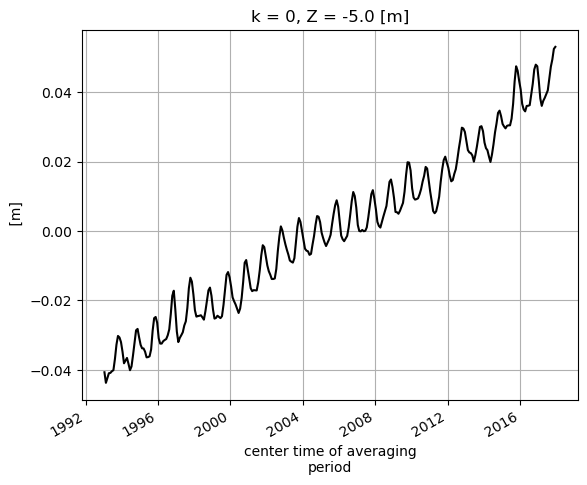

In [18]:
# and plot for fun
SSH_global_mean_mon.plot(color='k');plt.grid()

Alternatively we can do the summation over the three non-time dimensions.  The time dimension of SSH is along the first dimension (axis) of the array, axis 0.

In [19]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = np.sum(ecco_monthly_ds.SSH*ecco_monthly_ds.rA,axis=(1,2,3))/total_ocean_area
SSH_global_mean = SSH_global_mean.compute()

Even though *SSH* has 3 dimensions (time, tile, j, i) and *rA* and *ocean_mask.isel(k=0)* have 2 (j,i), we can mulitply them. With `xarray` the element-by-element multiplication occurs over their common dimension.

The resulting $SSH_{global-mean}$ `DataArray` has a single dimension, time.

#### Part 3 : Plotting the global mean sea level time series:

Before we plot the global mean sea level curve let's remove its time-mean to make it global mean sea level anomaly (the absolute value has no meaning here anyway).

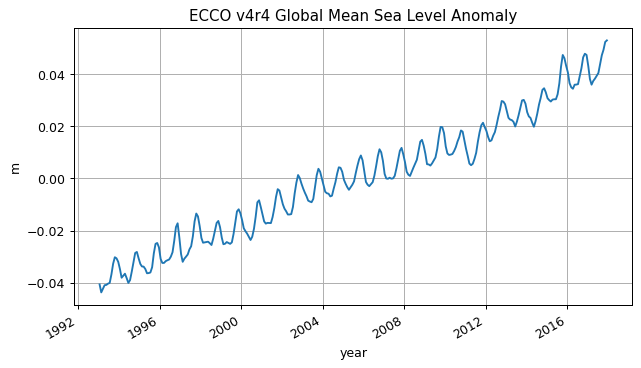

In [20]:
plt.figure(figsize=(8,4), dpi= 90)

# Method 1: .mean() method of `DataArrays`
SSH_global_mean_anomaly = SSH_global_mean - SSH_global_mean.mean()

# Method 2: numpy's `mean` method 
SSH_global_mean_anomaly = SSH_global_mean - np.mean(SSH_global_mean)

SSH_global_mean_anomaly.plot()
plt.grid()
plt.title('ECCO v4r4 Global Mean Sea Level Anomaly');
plt.ylabel('m');
plt.xlabel('year');

### Mean Dynamic Topography

Mean dynamic topography is calculated as follows,

$$ MDT(i) = \frac{\sum_{t} SSH(i,t) - SSH_{\text{global mean}}(t)}{nt} $$

Where $nt$ is the number of time records. 

For *MDT* we preserve the spatial dimensions. Summation and averaging are over the time dimensions (axis 0).

In [21]:
## Two equivalent methods

# Method 1, specify the axis over which to average
MDT = np.mean(ecco_monthly_ds.SSH - SSH_global_mean,axis=0)

# Method 2, specify the coordinate label over which to average
MDT_B = (ecco_monthly_ds.SSH - SSH_global_mean).mean(dim=['time'])

# which can be verified using the '.equals()' method to compare Datasets and DataArrays
print(MDT.equals(MDT_B))

True


As expected, MDT has preserved its spatial dimensions:

In [22]:
MDT.dims

('tile', 'j', 'i')

Before plotting the MDT field remove its spatial mean since its spatial mean conveys no dynamically useful information.  

In [23]:
MDT_no_spatial_mean = MDT - MDT*ecco_monthly_ds.rA/total_ocean_area

In [24]:
MDT_no_spatial_mean.shape

(13, 90, 90)

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


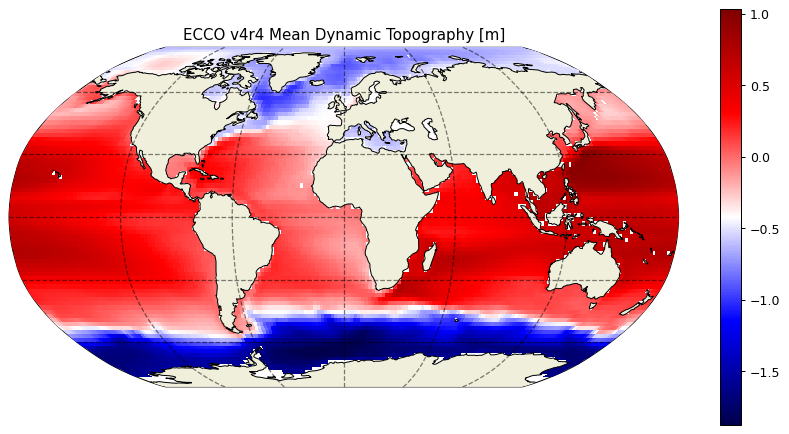

In [25]:
plt.figure(figsize=(12,6), dpi= 90)

# mask land points to Nan
MDT_no_spatial_mean = MDT_no_spatial_mean.where(ocean_mask[0,:] !=0)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              MDT_no_spatial_mean*ocean_mask.isel(k=0), \
                              user_lon_0=0,\
                              plot_type = 'pcolormesh', \
                              cmap='seismic',show_colorbar=True,\
                              dx=2,dy=2);

plt.title('ECCO v4r4 Mean Dynamic Topography [m]');

### Spatial variations of sea level linear trends  

To calculate the linear trend for the each model point we will use on the `polyfit` function of `numpy`.  First, define a time variable in years for SSH.

In [26]:
days_since_first_record = ((ecco_monthly_ds.time - ecco_monthly_ds.time[0])/(86400e9)).astype(int).values
len(days_since_first_record)

300

Next, reshape the four dimensional SSH field into two dimensions, time and space (t, i)

In [27]:
ssh_flat = np.reshape(ecco_monthly_ds.SSH.values, (len(ecco_monthly_ds.SSH.time), 13*90*90))
ssh_flat.shape

(300, 105300)

Now set all SSH values that are 'nan' to zero because the polynominal fitting
routine can't handle nans,

In [28]:
ssh_flat[np.nonzero(np.isnan(ssh_flat))] = 0
ssh_flat.shape

(300, 105300)

Do the polynomial fitting, https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html

In [29]:
# slope is in m / day
ssh_slope, ssh_intercept = np.polyfit(days_since_first_record, ssh_flat, 1)

print(ssh_slope.shape)

# and reshape the slope result back to 13x90x90    
ssh_slope = np.reshape(ssh_slope, (13, 90,90))

# mask 
ssh_slope_masked = np.where(ocean_mask[0,:] > 0, ssh_slope, np.nan)

# convert from m / day to mm/year
ssh_slope_mm_year = ssh_slope_masked*365*1e3

(105300,)


-179.5 113.5
-180.0 114.0
-89.5 89.5
-90.0 90.0
114.50770223076924 179.49230776923076
114.00001 180.0
-89.5 89.5
-90.0 90.0


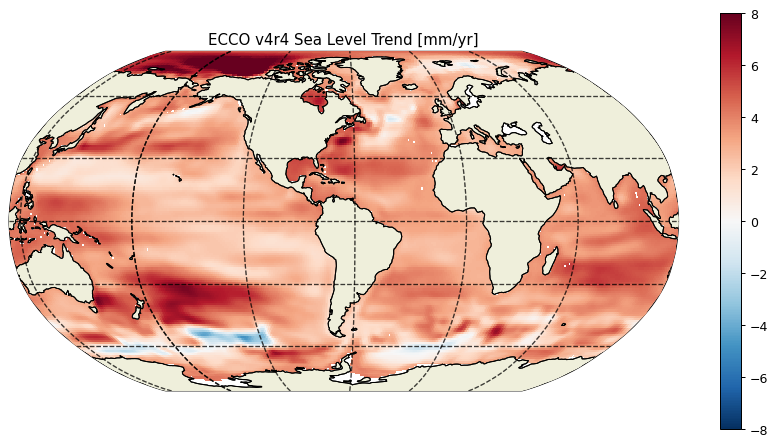

In [30]:
plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              ssh_slope_mm_year, \
                              user_lon_0=-66,\
                              plot_type = 'pcolormesh', \
                              show_colorbar=True,\
                              dx=1, dy=1, cmin=-8, cmax=8)

plt.title('ECCO v4r4 Sea Level Trend [mm/yr]');

And the mean rate of global sea level change in mm/year over the 1993-2017 period is:

In [31]:
((ssh_slope_mm_year*ecco_monthly_ds.rA).sum())/((ecco_monthly_ds.rA*ocean_mask.isel(k=0)).sum())

<xarray.DataArray ()>
array(3.21794046)
Coordinates:
    k        int32 0
    Z        float32 -5.0

## Constructing Monthly means from Daily means

We can also construct our own monthly means from the daily means using this command:
(See http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html for more information)

In [32]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean_day = (ecco_daily_ds.SSH*ecco_daily_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

In [33]:
# remove time mean from time series and replace with 1994 time mean from monthly SSH
SSH_global_mean_day = SSH_global_mean_day-SSH_global_mean_day.mean(dim='time')\
                        +SSH_global_mean_mon.sel(time='1994').mean(dim='time')

In [34]:
# add helpful unit label
SSH_global_mean_day.attrs['units']='m'

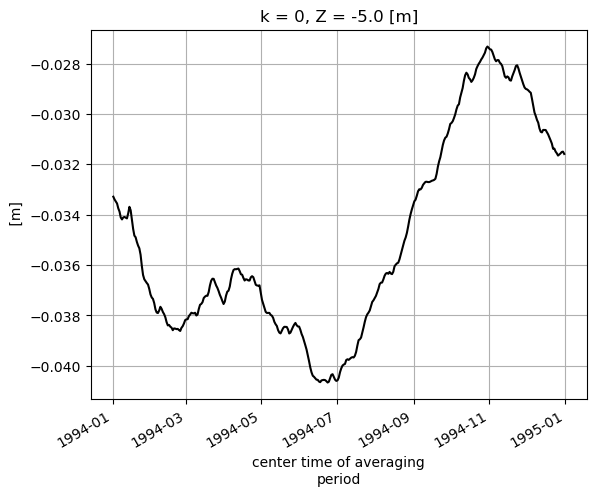

In [35]:
# and plot for fun
SSH_global_mean_day.plot(color='k');plt.grid()

In [36]:
SSH_global_mean_mon_alt = SSH_global_mean_day.resample(time='1M', loffset='-15D').mean()

Plot to compare.

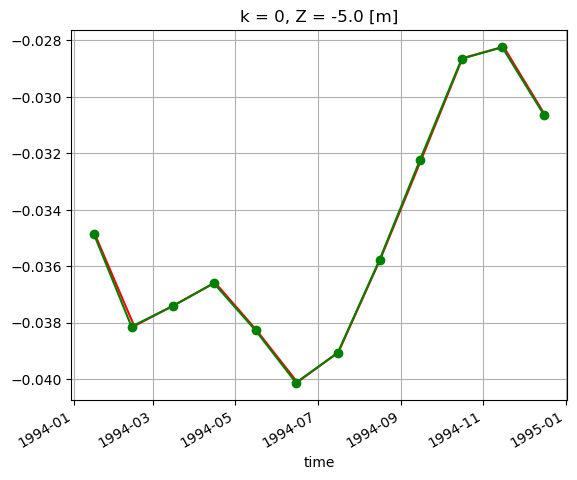

In [37]:
SSH_global_mean_mon.sel(time='1994').plot(color='r', marker='.');
SSH_global_mean_mon_alt.sel(time='1994').plot(color='g', marker='o');
plt.grid()

These small differences are simply an artifact of the time indexing.  We used loffset='15D' to shift the time of the monthly mean SSH back 15 days, close to the center of the month.  The SSH_global_mean_mon field is centered exactly at the middle of the month, and since months aren't exactly 30 days long, this results in a small discrepancy when plotting with a time x-axis.  If we plot without a time object x axis we find the values to be the same.  That's because ECCO monthly means are calculated over calendar months.

In [38]:
print ('date in middle of month')
print(SSH_global_mean_mon.time.values[0:2])
print ('\ndate with 15 day offset from the end of the month')
print(SSH_global_mean_mon_alt.time.values[0:2])

date in middle of month
['1993-01-16T12:00:00.000000000' '1993-02-15T00:00:00.000000000']

date with 15 day offset from the end of the month
['1994-01-16T00:00:00.000000000' '1994-02-13T00:00:00.000000000']


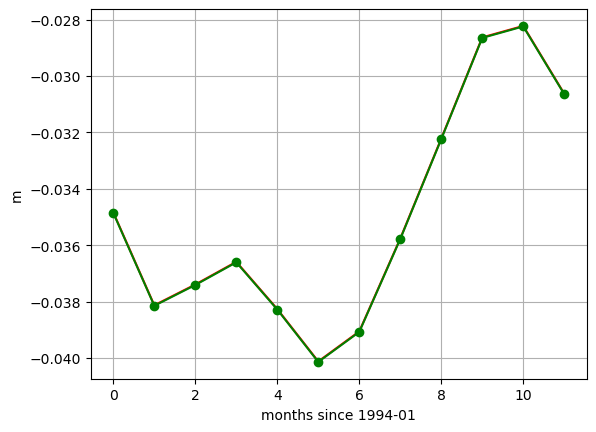

In [39]:
plt.plot(SSH_global_mean_mon.sel(time='1994').values, color='r', marker='.');
plt.plot(SSH_global_mean_mon_alt.sel(time='1994').values, color='g', marker='o');
plt.xlabel('months since 1994-01');
plt.ylabel('m')
plt.grid()

## Regional calculations with THETA

In [40]:
lat_bounds = np.logical_and(ecco_monthly_ds.YC >= -5, ecco_monthly_ds.YC <= 5)
lon_bounds = np.logical_and(ecco_monthly_ds.XC >= -170, ecco_monthly_ds.XC <= -120)

SST = ecco_monthly_ds.THETA.isel(k=0)
SST_masked=SST.where(np.logical_and(lat_bounds, lon_bounds))

-179.875 113.875
-180.0 114.0
-89.875 89.875
-90.0 90.0
114.1254852661597 179.8745247338403
114.00001 180.0
-89.875 89.875
-90.0 90.0


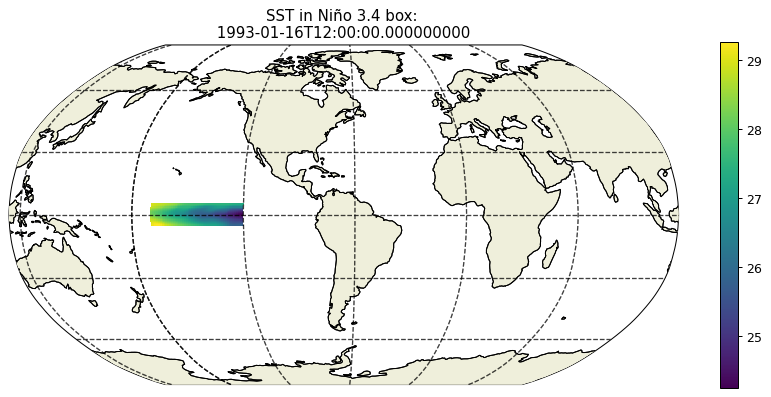

In [41]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              SST_masked.isel(time=0),\
                              user_lon_0 = -66,\
                              show_colorbar=True);

plt.title('SST in Niño 3.4 box: \n %s ' % str(ecco_monthly_ds.time[0].values));

In [42]:
# Create the same mask for the grid cell area
rA_masked=ecco_monthly_ds.rA.where(np.logical_and(lat_bounds, lon_bounds));

# Calculate the area-weighted mean in the box
SST_masked_mean=(SST_masked*rA_masked).sum(dim=['tile','j','i'])/np.sum(rA_masked)

# Substract the temporal mean from the area-weighted mean to get a time series, the Nino 3.4 index
SST_nino_34_anom_ECCO_monthly_mean = SST_masked_mean - np.mean(SST_masked_mean)

### Load up the Niño 3.4 index values from ESRL

In [43]:
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
# NINA34
# 5N-5S 170W-120W 
# HadISST 
#  Anomaly from 1981-2010
#  units=degC

import urllib.request
data = urllib.request.urlopen('https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data')

# the following code parses the ESRL text file and puts monthly-mean nino 3.4 values into an array
start_year = 1993
end_year = 2017
num_years = end_year-start_year+1
nino34_noaa = np.zeros((num_years, 12))
for i,l in enumerate(data):
    line_str = str(l, "utf-8")
    x=line_str.split()
    try:
        year = int(x[0])
        row_i = year-start_year
        if row_i >= 0 and year <= end_year:
            
            print('loading Niño 3.4 for year %s  row %s' % (year, row_i))

            for m in range(0,12):
                nino34_noaa[row_i, m] = float(x[m+1])
    except:
        continue


loading Niño 3.4 for year 1993  row 0
loading Niño 3.4 for year 1994  row 1
loading Niño 3.4 for year 1995  row 2
loading Niño 3.4 for year 1996  row 3
loading Niño 3.4 for year 1997  row 4
loading Niño 3.4 for year 1998  row 5
loading Niño 3.4 for year 1999  row 6
loading Niño 3.4 for year 2000  row 7
loading Niño 3.4 for year 2001  row 8
loading Niño 3.4 for year 2002  row 9
loading Niño 3.4 for year 2003  row 10
loading Niño 3.4 for year 2004  row 11
loading Niño 3.4 for year 2005  row 12
loading Niño 3.4 for year 2006  row 13
loading Niño 3.4 for year 2007  row 14
loading Niño 3.4 for year 2008  row 15
loading Niño 3.4 for year 2009  row 16
loading Niño 3.4 for year 2010  row 17
loading Niño 3.4 for year 2011  row 18
loading Niño 3.4 for year 2012  row 19
loading Niño 3.4 for year 2013  row 20
loading Niño 3.4 for year 2014  row 21
loading Niño 3.4 for year 2015  row 22
loading Niño 3.4 for year 2016  row 23
loading Niño 3.4 for year 2017  row 24


Text(0.5, 1.0, 'Niño3.4 index from ECCO')

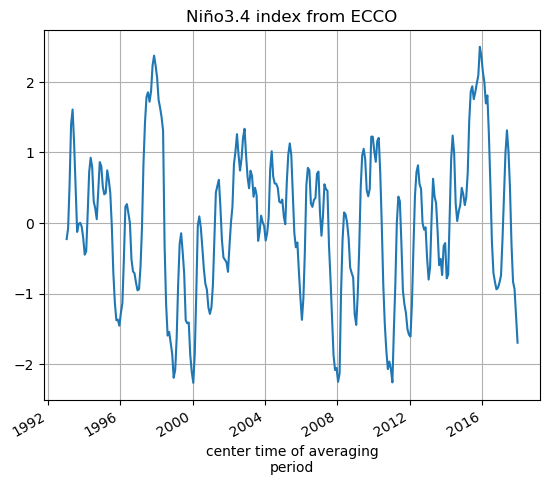

In [44]:
SST_nino_34_anom_ECCO_monthly_mean.plot();plt.grid()
plt.title('Niño3.4 index from ECCO')

we'll make a new DataArray for the NOAA SST nino_34 data by copying the DataArray 
for the ECCO SST data and replacing the values

In [45]:
SST_nino_34_anom_NOAA_monthly_mean = SST_nino_34_anom_ECCO_monthly_mean.copy(deep=True)
SST_nino_34_anom_NOAA_monthly_mean.values[:] = nino34_noaa.ravel()

Text(0.5, 1.0, 'Niño3.4 index from NOAA ESRL')

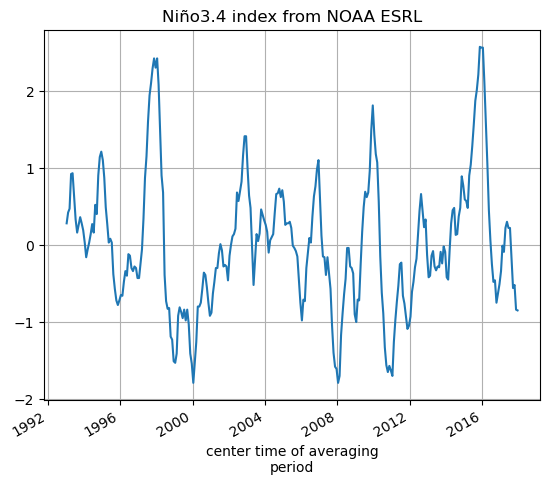

In [46]:
SST_nino_34_anom_NOAA_monthly_mean.plot();plt.grid()
plt.title('Niño3.4 index from NOAA ESRL')

### Plot the ECCOv4r4 and ESRL Niño 3.4 index

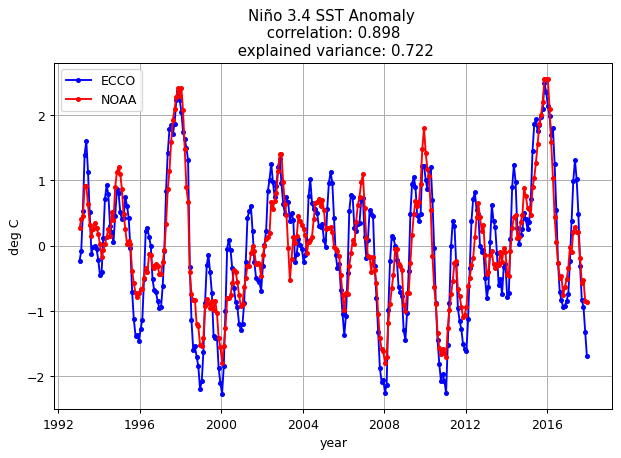

In [47]:
# calculate correlation between time series
nino_corr = np.corrcoef(SST_nino_34_anom_ECCO_monthly_mean, SST_nino_34_anom_NOAA_monthly_mean)[1]
nino_ev   = 1 - np.var(SST_nino_34_anom_ECCO_monthly_mean-SST_nino_34_anom_NOAA_monthly_mean)/np.var(SST_nino_34_anom_NOAA_monthly_mean)
plt.figure(figsize=(8,5), dpi= 90)
plt.plot(SST_nino_34_anom_ECCO_monthly_mean.time, \
             SST_nino_34_anom_ECCO_monthly_mean - SST_nino_34_anom_ECCO_monthly_mean.mean(),'b.-')
plt.plot(SST_nino_34_anom_NOAA_monthly_mean.time, \
             SST_nino_34_anom_NOAA_monthly_mean - SST_nino_34_anom_NOAA_monthly_mean.mean(),'r.-')
plt.title('Niño 3.4 SST Anomaly \n correlation: %s \n explained variance: %s' % (np.round(nino_corr[0],3), \
                                                                                 np.round(nino_ev.values,3)));
plt.legend(('ECCO','NOAA'))
plt.ylabel('deg C');
plt.xlabel('year');
plt.grid()

ECCO is able to match the NOAA Niño 3.4 index fairly well.

## Conclusion

You should now be familiar with doing some doing calculations using scalar quantities.

### Suggested exercises

1. Create the global mean SSH time series from 1992-2015
2. Create the global mean sea level trend (map) from 1992-2015
3. Create the global mean sea level trend (map) for two epochs 1992-2003, 2003-2015
4. Compare other Niño indices
